# Beach Photography - Business Analysis Notebook

![sample_photo.jpg](./sample_photo.jpg?raw=true)

### Introduction

This project is an exercise in Competitive Business Analysis.  It centers around a business that specializes in beach photography: For a fee, the company will send a professional photographer out for one hour to capture high-end photos of your family enjoying your beach vacation.

As the main purpose of this notebook is to demonstrate the generation of meaningful visualizations (rather than to delve deeply into business strategy), the notebook is fairly code-heavy.  Feel free to skip around, skim the graphs, or just read the Conclusion at the bottom of the page.

Before composing this notebook, I built a web scraper to scrape the business's website.  Curiously, the business leaves most of their customers' data in the public for anyone to find.  From their website I downloaded over 100,000 photos and captured anonymized client data.  The code for the scraper I built can be found here: [Scraper](https://github.com/zetterlund/Multithreaded-Scraper/blob/master/scraper.py).

## Imports:

### Standard Imports

In [1]:
%matplotlib inline
from datetime import datetime
import pandas as pd
import numpy as np
import math
import re
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
# plt.style.use('seaborn')

start_program = datetime.now() # Let's see how long it takes the program to run
BASE_DIR = '/home/sven/promethium/projects/beach-pics'

Set up Error Logging:

In [2]:
import logging

file_handler = logging.FileHandler('data_analysis_debug.log')
stream_handler = logging.StreamHandler()
stream_handler.setLevel(logging.ERROR)
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s:%(name)s:%(levelname)s:%(threadName)s:%(funcName)s - %(message)s',
                    handlers=(file_handler, stream_handler))

Configure settings for nicer-looking graphs:

In [3]:
plt.rcParams['font.sans-serif'] = 'Roboto'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.weight'] = 'light'

plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'light'
plt.rcParams['axes.titlepad'] = 14
plt.rcParams['axes.facecolor'] = '#f0f9ff'
plt.rcParams['axes.edgecolor'] = '#000000'
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'semibold'
plt.rcParams['axes.labelpad'] = 6

plt.rcParams['figure.facecolor'] = '#ffffff'
plt.rcParams['figure.figsize'] = (10, 6)

plt.rcParams['legend.facecolor'] = '#ffffff'
plt.rcParams['legend.fontsize'] = 12

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

In [4]:
from matplotlib.colors import LinearSegmentedColormap

# Custom colormaps
def get_colormap(style, N):
    colors = {
        'cool': ['#3c9c35', '#3273a8'],
        'multi': ['#3273a8', '#a83232', '#b8b321'],
        'correlation': ['#3c9c35', '#000000']
    }    
    my_colormap = LinearSegmentedColormap.from_list('colormap', colors[style], N=N)
    cm = plt.cm.get_cmap(my_colormap, N)
    return cm

### Import Data

Now let's load our data that we're going to work with.  As mentioned in the Introduction, the data was captured by scraping the site using [this](https://github.com/zetterlund/Multithreaded-Scraper/blob/master/scraper.py) scraping script.  The scraped data was saved to a MongoDB database, so let's retrieve the data now.

In [5]:
from pymongo import MongoClient

client = MongoClient()
db = client['beach_pics']

# Duplicate the collection, just to make sure we don't tamper with the original database files
db.drop_collection('profiles_analysis')
db['profiles_analysis'].insert_many(db['profiles'].find())

In [6]:
print('Total records found: {}\n'.format(len(list(db['profiles_analysis'].find({})))))

print('Sample document keys:')
for key in sorted(list(db['profiles_analysis'].find_one())):
    print('--', key)

Total records found: 2416

Sample document keys:
-- _id
-- account_locked
-- data_clientid
-- data_url
-- name
-- photo_count_on_site
-- photo_info_scraped
-- photos_scraped
-- profile_pic_style
-- profile_pic_url
-- result_page_placement
-- search_url
-- surname


## Feature Enginering:

The first step we'll take will be to generate new data points from existing ones in order to enrich our dataset for better analysis.

### Date

For example, one of the things we want to gather information on is when the photos were taken.  This will allow us to plot trends over time to get a better sense of the business.

There are actually two possible sources from which to extract 'Date' information:
- In the EXIF data of the photos we downloaded
- Extracted from the profile name data (e.g. "**Donna Smith 3/14/17**")

Let's first add the photo EXIF data as datapoints to the profiles in our database:

In [7]:
import os
import exifread


def insert_exif_data(document):    
    base_directory = BASE_DIR
    
    photo_info = {
        'image_datetime': None,
        'datetime_digitized': None,
        'datetime_original': None,
        'model': None
    }    
    
    if document['account_locked'] == False and document['photo_count_on_site'] > 0:        
        try:
            photo_dir = os.path.join(base_directory, 'analysis-photos', document['_id'], 'M')
            photo_filename = os.listdir(photo_dir)[0]    
            photo_path = os.path.join(photo_dir, photo_filename)
            with open(photo_path, 'rb') as f:
                tags = exifread.process_file(f)

            if tags.get('Image DateTime', None):
                photo_info['image_datetime'] = datetime.strptime(str(tags['Image DateTime']), '%Y:%m:%d %H:%M:%S')
            if tags.get('EXIF DateTimeDigitized', None):
                photo_info['datetime_digitized'] = datetime.strptime(str(tags['EXIF DateTimeDigitized']), '%Y:%m:%d %H:%M:%S')
            if tags.get('EXIF DateTimeOriginal', None):
                photo_info['datetime_original'] = datetime.strptime(str(tags['EXIF DateTimeOriginal']), '%Y:%m:%d %H:%M:%S')
            if tags.get('Image Model', None):
                photo_info['model'] = re.sub(r'^[\"\']+([^\"\']*)[\"\']+$', r'\1', str(tags['Image Model']))

        except Exception as e:
            logging.error("Top-level error.  photo_path: {}  error: {}".format(photo_path, e))
        
    db['profiles_analysis'].update_one({'_id': document['_id']}, {"$set": photo_info})
    

for p in list(db['profiles_analysis'].find()):
    insert_exif_data(p)

Let's now extract 'Date' information from the profile names:

In [8]:
def insert_name_date(document):    
    name_date = document['name']

    pattern = re.compile('^.*?((\d+)[\.\/\-]+(\d+)[\.\/\-]+(\d+)).*$')    
    name_date = re.search(pattern, name_date)
    
    try:
        if name_date is not None:
            month_string = name_date.group(2)
            day_string = name_date.group(3)
            year_string = name_date.group(4)

            if len(year_string) == 2:
                year_string = '20' + year_string
            if len(month_string) == 1:
                month_string = '0' + month_string
            if len(day_string) == 1:
                day_string = '0' + day_string

            name_date = datetime.strptime('{}-{}-{}'.format(month_string, day_string, year_string), '%m-%d-%Y')
    except Exception as e:
        logging.warning('Problem extracting name_date from name.  Setting name_date to None and continuing.\ndocument["name"]: {}\nerror: {}\n'.format(document['name'], e))
        name_date = None

    db['profiles_analysis'].update_one({'_id': document['_id']}, {"$set": {'name_date': name_date}})
    
    
for p in list(db['profiles_analysis'].find()):
    insert_name_date(p)

(Regardless of which combination of data is available for each record, let's formalize that Date information and save it into a "date_added" field.)

In [9]:
for p in db['profiles_analysis'].find():
    
    date_added = None
    
    if p['datetime_original']:
        date_added = p['datetime_original']
    elif p['name_date']:
        date_added = p['name_date']  

    db['profiles_analysis'].update_one({'_id': p['_id']}, {"$set": {'date_added': date_added}})

Now I'm curious: Was it worth it to extract Date information from both sources?  Let's take a look to see how many accounts contained each of those data points.

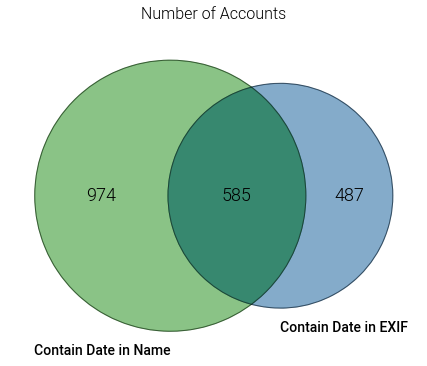

In [10]:
from matplotlib_venn import venn2, venn2_circles

sets = {
    '01': 0,
    '11': 0,
    '10': 0
}

for p in db['profiles_analysis'].find():
    if p['name_date'] is not None and p['datetime_original'] is not None:
        sets['11'] += 1
        continue
    if p['name_date'] is not None:
        sets['10'] += 1
        continue
    if p['datetime_original'] is not None:
        sets['01'] += 1
        continue
        
plt.figure()
v = venn2(subsets = sets,
          set_labels = ['Contain Date in Name', 'Contain Date in EXIF'],
          ax = plt.gca())
c=venn2_circles(subsets = sets, linewidth=1, color='black', alpha=0.5)

cm = get_colormap('cool', 3)
v.get_patch_by_id('10').set_alpha(0.6)
v.get_patch_by_id('10').set_color(cm(0))
v.get_patch_by_id('01').set_alpha(0.6)
v.get_patch_by_id('01').set_color(cm(2))
v.get_patch_by_id('11').set_alpha(1)
v.get_patch_by_id('11').set_color(cm(1))

for text in v.subset_labels:
    text.set_fontsize(18)
for text in v.set_labels:
    text.set_fontsize(14)
    text.set_fontweight('semibold')

plt.title('Number of Accounts', fontdict={'fontsize': 16})
plt.show()

Many profiles were missing one of the data points, so it looks like it was indeed beneficial to extract 'Date' information from both data points.

### Processing Time

The next feature we'll generate will be "Processing Time".  This is the time between when a photo was taken and when it was uploaded to the website.

In [11]:
for p in db['profiles_analysis'].find():
    try:
        d = (p['image_datetime'] - p['datetime_original']).total_seconds()
    except:
        d = None
    finally:
        db['profiles_analysis'].update_one({'_id': p['_id']}, {"$set": {'processing_time': d}})

## Data Analysis:

For Data Analysis, let's utilize the Pandas library, and load our profiles into a Pandas DataFrame object.

In [12]:
profiles = pd.DataFrame(list(db['profiles_analysis'].find()))

### Account Types

The website gives users the option of privatizing their photos.  Let's look at how many accounts are private:

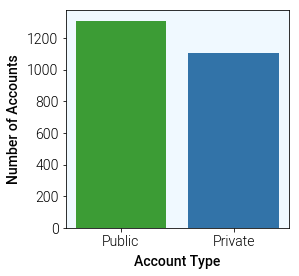

Percent of all accounts on site that were public: 54%


In [13]:
public_count = len(profiles.loc[profiles['account_locked'] == False])
private_count = len(profiles.loc[profiles['account_locked'] == True])

x = ['Public', 'Private']
y = [public_count, private_count]

plt.figure(figsize=(4, 4))

cm = get_colormap('cool', 2)
plt.bar(x, y, color=[cm(0), cm(1)])
plt.xlabel('Account Type')
plt.ylabel('Number of Accounts')
plt.show()

print('Percent of all accounts on site that were public: {}%'.format(int((public_count / (public_count + private_count)) * 100)))

### Number of Photos per Account

In [14]:
# Restrict our set to only public profiles
df = profiles.loc[profiles['account_locked'] == False]

photo_count_max = max(df['photo_count_on_site'])
print('Maximum photo count for one account: {} photos!'.format(photo_count_max))

# Exclude outlying values
df = df.loc[(df['photo_count_on_site'] < 800)]

photo_count_average = int(np.median(df['photo_count_on_site']))
print('Average photo count: {} photos'.format(photo_count_average))

Maximum photo count for one account: 2202 photos!
Average photo count: 127 photos


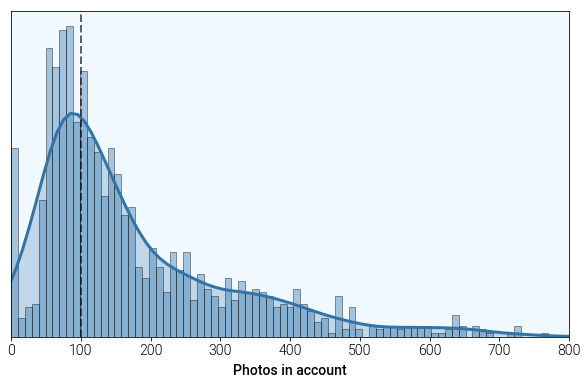

In [15]:
sns.distplot(df['photo_count_on_site'],
             hist=True,
             kde=True,
             bins=78,
             color=get_colormap('cool', 2)(1), 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3, 'shade': True})

plt.axvline(x=100, color='black', alpha=0.8, dashes=(5,2))

plt.xlim(0, 800)
plt.xlabel('Photos in account')
plt.yticks([])
plt.show()

To save hard drive space, I only downloaded a sample of up to 100 photos from each account.  I'm curious to see what percentage of all the photos on the site I ended up downloading:

In [16]:
percent_photos_downloaded = int( \
    np.sum(list(map(lambda x: min(x, 100), df['photo_count_on_site']))) / \
    sum(df['photo_count_on_site']) * 100)
print('Percent of all available photos on site downloaded: {}%'.format(percent_photos_downloaded))

Percent of all available photos on site downloaded: 48%


### Average Profile Processing Time

Let's see how long it takes for the photographers to make the photos available to the client once they have been taken in the field.

In [17]:
s = profiles['processing_time']

s = s.dropna() # Drop records with NaN values
s = s.drop(s[(s <= 10) | (s > 720000)].index) # Drop records with outlying values
s = s.apply(lambda x: x/3600) # (Convert time difference from seconds to hours)

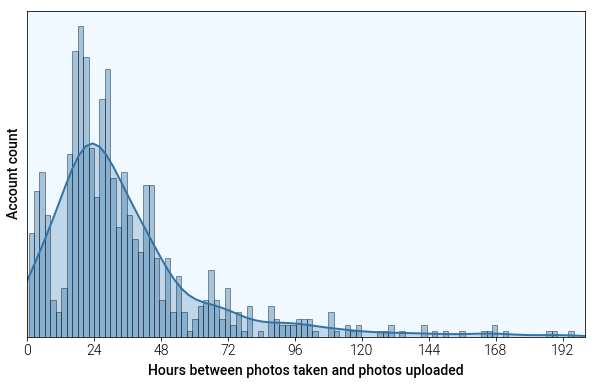

Average time between photos being taken and photos being uploaded: 27.9 hours


In [18]:
ax = sns.distplot(s.values,
                  hist=True,
                  kde=True,
                  bins=100,
                  color=get_colormap('cool', 2)(1),
                  hist_kws={'edgecolor':'black'},
                  kde_kws={'linewidth': 2, 'shade': True})

plt.xticks(np.array(range(9))*24)
plt.yticks([])
plt.xlim(0, 200)
plt.xlabel('Hours between photos taken and photos uploaded')
plt.ylabel('Account count')

plt.show()

print('Average time between photos being taken and photos being uploaded: {} hours'.format(round(np.median(s), 1)))

They don't waste much time!

## Time Analysis

Next up, let's analyze how things have changed over time.

Let's first drop those accounts that don't have any Date information:

In [19]:
profiles.drop(profiles[profiles['date_added'].isna()].index, inplace=True)
profiles.reset_index(inplace=True, drop=True)

profiles['date_year'] = profiles.apply(lambda x: x['date_added'].year, axis=1)
profiles['date_year_month'] = profiles['date_added'].apply(lambda x: datetime(x.year, x.month, 1))

In [20]:
print(profiles.groupby('date_year').size())

date_year
2000     15
2010      2
2011      1
2012      2
2013      8
2014    128
2015    352
2016    240
2017    433
2018    512
2019    353
dtype: int64


It looks like there weren't many profiles from before 2014 (and the outliers in 2000 are probably erroneous data), so let's drop those older profiles:

In [21]:
profiles.drop(profiles[profiles['date_year'] < 2014].index, inplace=True)

### Average Number of Photos over Time

In [22]:
# Restrict our set to only public profiles
df = profiles.loc[profiles['account_locked'] == False]

gb = df.groupby('date_year')['photo_count_on_site'].aggregate(median=(lambda x: np.median(x)),
                                                              p1=(lambda x: np.percentile(x, q=90)),
                                                              p2=(lambda x: np.percentile(x, q=10)))

In [23]:
years = list()

m = list()
p1 = list()
p2 = list()

for i, x in gb.iterrows():
    years.append(i)
    m.append(x['median'])
    p1.append(x['p1'])
    p2.append(x['p2'])    

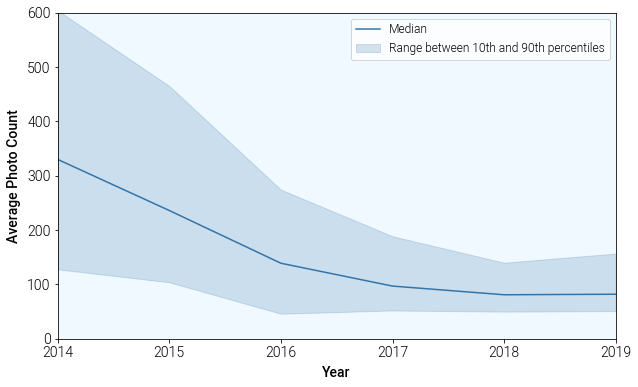

In [24]:
plt.figure(figsize=(10,6))


cm = get_colormap('cool', 2)
plt.plot(years, m, label="Median", color=cm(1))
plt.fill_between(years, p1, p2, color=cm(1), alpha=0.2, label="Range between 10th and 90th percentiles")

plt.xlim(2014, 2019)
plt.ylim(0, 600)

plt.xlabel('Year')
plt.ylabel('Average Photo Count')

plt.legend(loc='upper right')
plt.show()

It looks like the number of photos has gone down in recent years.  Customers don't want to slog through hundreds of photos.  Plus, it could help the editors save time to only pick a smaller number to edit and upload.

### Business Growth over Time

Now let's start plotting variables over time to see how the business has changed.

In [25]:
# Group dataset by each year/status combination

profiles['account_locked'] = profiles['account_locked'].apply(lambda x: 'private' if x else 'public')
df = profiles.groupby(['account_locked', 'date_year']).size().reset_index(name='counts')

unique_years = sorted(profiles.date_year.unique())
unique_statuses = sorted(profiles.account_locked.unique())

status_counts = {x: [] for x in unique_statuses}
for year in unique_years:
    for status in unique_statuses:
        index = df.loc[(df['date_year'] == year) & (df['account_locked'] == status)].index
        status_counts[status].append(df.loc[index[0], 'counts'] if not index.empty else 0)

In [26]:
# Create linear regression to model business growth over time

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

df2 = profiles.groupby(['date_year']).size().reset_index(name='counts')
x2 = df2['date_year'].values
y2 = df2['counts'].values

regression = LinearRegression().fit(x2.reshape(-1, 1), y2.reshape(-1, 1))
preds = regression.predict(x2.reshape(-1, 1))
reg_score = round((r2_score(y2, preds) ** 0.5), 3)

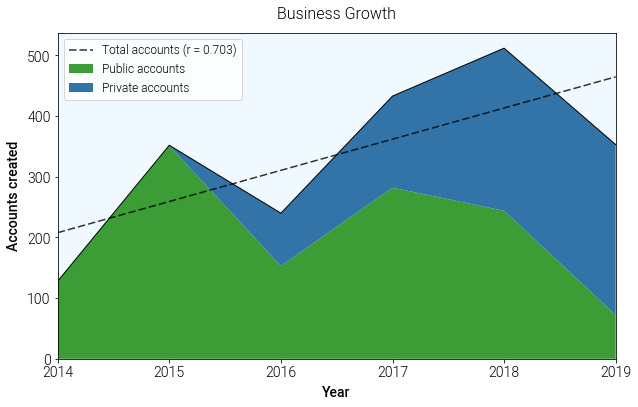

In [27]:
plt.figure(figsize=(10,6))
cm = get_colormap('cool', 2)

# Plot the data
x = unique_years
y = [status_counts['public'], status_counts['private']]
plt.stackplot(x, y, labels=['Public accounts','Private accounts'], colors=[cm(0), cm(1)])
plt.plot(x, np.add(y[0], y[1]), lw=1, color='#000000')

# Plot linear regression
plt.plot(x2, preds, color='#000000', alpha=0.8, dashes=(5, 2), label='Total accounts (r = {})'.format(reg_score))

plt.xlabel('Year')
plt.ylabel('Accounts created')
plt.title('Business Growth')

plt.xlim(2014, 2019)
plt.legend(loc='upper left')

plt.show()

We can draw two conclusions from the graph:
1. The number of profiles has been increasing over time 
1. The number of private profiles is growing; the number of public profiles is shrinking

So the business is growing, and they're increasing their privacy.

(Note, I'm creating this notebook partway through 2019 so this year's data is lower than it will be at year's end.)

### Identifying the Most-Profitable Time of Year

Let's take a look at which time of year most photos are taken.

1. First, we'll identify the busiest 30-day window of time in the year.
1. Second, we'll see which window of time contains 80% of all the business.

Let's use the Pareto Principle to get the most bang for our buck.  It doesn't make sense to operate the business 12 months of the year if most of the business comes during just a few peak months.

*Note: a more in-depth business analysis is necessary in order to judge whether we'd truly be better off operating only during peak months.  We need more information on the fixed and variable costs of running the business.  If we were to start this business, we would start with the peak months, and then run some cost analyses to decide whether to expand the business to be a year-long operation.*

In [28]:
# Generate a time-of-year data point: (e.g. May 5th is day 125/365)

month_day_list = profiles['date_added'].map(lambda x: x.timetuple().tm_yday)

#### Identifying the Busiest 30-Day Window of the Year:

In [29]:
from datetime import timedelta

date_counts = [0 for x in range(366)]
for index, value in month_day_list.value_counts().iteritems():
    date_counts[index] = value

window = 30
maximum_sum = 0
maximum_index = 0

for i in range(len(date_counts)):
    new_sum = sum(date_counts[i : i + window])
    if new_sum > maximum_sum:
        maximum_sum = new_sum
        maximum_index = i
        
d1 = datetime.strftime(datetime(datetime.today().timetuple().tm_year, 1, 1) + timedelta(maximum_index), '%B %d')
d2 = datetime.strftime(datetime(datetime.today().timetuple().tm_year, 1, 1) + timedelta(maximum_index + 29), '%B %d')

print("The busiest 30 days of the year are:\n{} to {}".format(d1, d2))

The busiest 30 days of the year are:
July 02 to July 31


Ah, just as expected.  Families come to the beach for vacation more often in the summer than any other time of year, and the month of July in particular is the busiest.

#### Identifying the Time of Year that contains 80% of all Sales:

In [30]:
# A function that returns the window of time which contains X percent of all the accounts
def get_date_percentiles(date_list, percentile):
    p1 = np.percentile(date_list, (100-percentile)/2)
    p2 = np.percentile(date_list, 100 - (100-percentile)/2)
    d1 = datetime.strftime(datetime(datetime.today().timetuple().tm_year, 1, 1) + timedelta(p1 - 1), '%B %d')
    d2 = datetime.strftime(datetime(datetime.today().timetuple().tm_year, 1, 1) + timedelta(p2 - 1), '%B %d')    
    return p1, p2, d1, d2

percentile = 80
p1, p2, d1, d2 = get_date_percentiles(month_day_list, percentile)

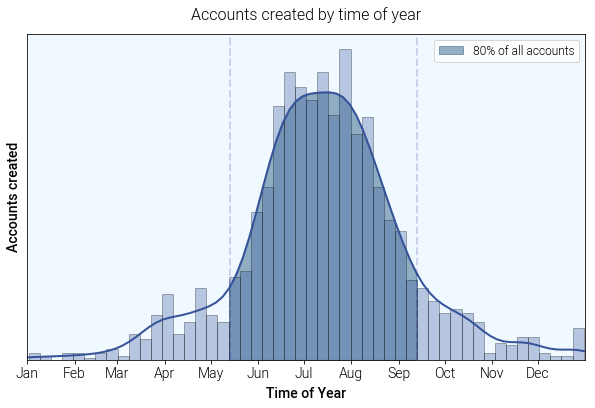

In order to capture 80% of the listings:
Begin: May 13
End: September 15
Total length: 124 days


In [31]:
ax = sns.distplot(month_day_list,
                  hist=True,
                  kde=True,
                  bins=50,
                  color='#365399',
                  hist_kws={'edgecolor':'black', 'alpha': 0.3},
                  kde_kws={'linewidth': 2, 'shade': False})

plt.axvline(x=p1,color='darkblue', alpha=0.2, dashes=(5,2))
plt.axvline(x=p2-2,color='darkblue', alpha=0.2, dashes=(5,2))
kde_x, kde_y = ax.lines[0].get_data()
ax.fill_between(kde_x, kde_y, where=(kde_x >= p1-2) & (kde_x <= p2), color='#003e69', alpha=0.4, label="80% of all accounts")

plt.xlim(1, 366)
month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_list = [(m ,datetime.strptime(m, '%b').timetuple().tm_yday) for m in month_list]
plt.xticks([m[1] for m in month_list], [m[0] for m in month_list])
plt.yticks([])

plt.xlabel('Time of Year')
plt.ylabel('Accounts created')
plt.title('Accounts created by time of year')
plt.legend(loc='upper right')

plt.show()

print("In order to capture {}% of the listings:\nBegin: {}\nEnd: {}\nTotal length: {} days".format(percentile, d1, d2, int(p2-p1)))

Besides the big summer push, we can also see little localized humps throughout the year.  There's one in April for Spring Break, then little bumps around Thanksgiving and Christmas.  Still, the numbers are low compared to those of the summer season.  If we were to create our own beach pictures business, the best time of year to be operating is summer.

### Number of Photographers/Contractors working for the Business

Another thing I wanted to try to find is how many employees/contractors are working for the business.  The lower the number, the better: This would indicate low employee turnover and the fact that the business can successfully run with fewer workers.  We'll look at two data points to try to spot trends:

1. There is a 'data_clientid' value, and I suspect this might be an internal code for which employee took the photos.
2. There is a 'model' value which contains the camera model used to take the photographs.

Keep in mind that with these data points **there's some uncertainty, because we can only access this data from public profiles.**

In [32]:
# Group dataset by each 'year'/'data_clientid' combination

df = profiles.groupby(['data_clientid', 'date_year']).size().reset_index(name='counts')

unique_years = sorted(df.date_year.unique())
unique_clientids = sorted(df.data_clientid.unique())

counts_dict = {x: {y: 0 for y in unique_clientids} for x in unique_years}
for i, x in df.iterrows():
    counts_dict[x.date_year][x.data_clientid] = x.counts

counts = [[x, []] for x in unique_clientids]
year_list = list()
for year in unique_years:
    for i, clientid in enumerate(unique_clientids):
        counts[i][1].append(counts_dict[year][clientid])
    year_list.append(year)

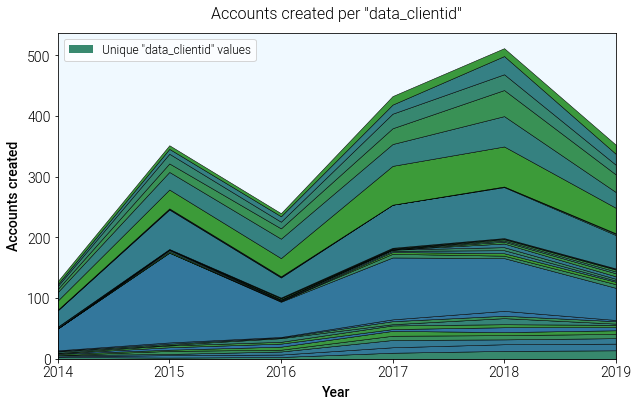

In [33]:
x = year_list
y = [c[1] for c in counts]

# Get random colormap to make the graph look nicer
import random
c_list = list(range(len(counts)))
random.shuffle(c_list)
cm = get_colormap('cool', len(y))
c_list = [cm(i) for i in c_list]

plt.stackplot(x, y, colors=c_list, lw=0.5, edgecolor='#000000')

plt.xlim(2014, 2019)
plt.xlabel('Year')
plt.ylabel('Accounts created')
plt.title('Accounts created per "data_clientid"')

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=get_colormap('cool', 3)(1), label='Unique "data_clientid" values')]
plt.legend(handles=legend_elements, loc='upper left')

plt.show()

The graph on its own doesn't tell us very much.  But if you look closer, most of the bands seem to be following the same trend, growing and shrinking together.

Let's plot a correlation graph showing the average correlation of each of the 30 unique 'data_clientid' values to all of the others.

In [34]:
value_matrix = [c[1] for c in counts]

coeff_matrix = np.corrcoef(value_matrix)
coeff_means = [abs(np.median(x)) for x in coeff_matrix]

# Create dictionary to match data_clientid value to average correlation value:
coeff_dict = {a: b for a, b in zip([c[0] for c in counts], coeff_means)}

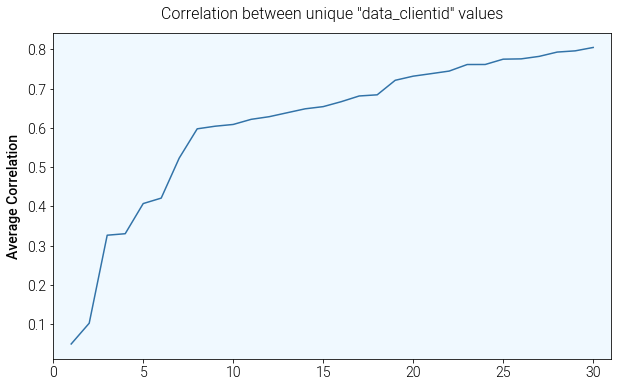

In [35]:
x = range(1, len(coeff_means)+1)
y = sorted(coeff_means)
plt.plot(x, y, color=get_colormap('cool', 2)(1))

plt.xlim(0, 31)

plt.ylabel('Average Correlation')
plt.title('Correlation between unique "data_clientid" values')
plt.show()

It looks like only several of the unique 'data_clientid' values are not correlated with each other.  I would guess that this is closer to the true number of contractors who are out in the field taking photos.

Let's look at how many accounts each 'data_clientid' value created, and also take into account the value's correlation to the other 'data_clientid' values.

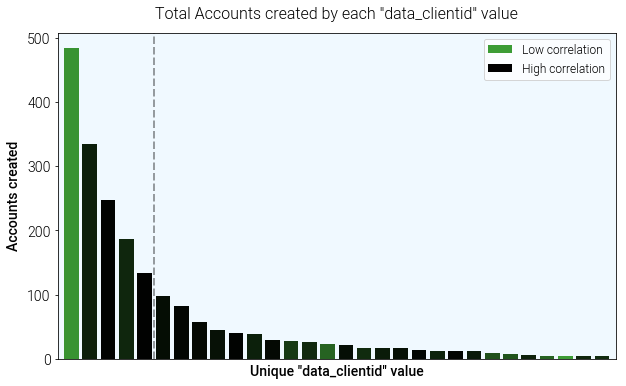

68% of Accounts were created by the top 5 "data_clientid" values


In [36]:
df = profiles.groupby(['data_clientid']).size().reset_index(name='counts')
df.sort_values(by='counts', axis=0, ascending=False, inplace=True)

x = range(1, len(df['data_clientid'])+1)
y = df['counts']

# Set up custom colorbar to match correlation values
r = 100
m = (r-1) / (max(coeff_means) - min(coeff_means))
colors = [coeff_dict[x] for x in df['data_clientid']]
colors = [int((x - min(coeff_means)) * m) for x in colors]
cm = get_colormap('correlation', r)

plt.bar(x, y, color=cm(colors))
plt.axvline(x=5.5,color='black', alpha=0.5, dashes=(5,2))

plt.xlim(0.25, len(df['data_clientid'])+0.75)

plt.xlabel('Unique "data_clientid" value')
plt.ylabel('Accounts created')
plt.title('Total Accounts created by each "data_clientid" value')
plt.xticks([])

# cm = get_colormap('multi', 3)
legend_elements = [Patch(facecolor=cm(0), label='Low correlation'),
                   Patch(facecolor=cm(99), label='High correlation')]
plt.legend(handles=legend_elements, loc='upper right')

plt.show()

top_clientids_percentile = int(sum(df['counts'][:5]) / sum(df['counts']) * 100)
print('{}% of Accounts were created by the top 5 "data_clientid" values'.format(top_clientids_percentile))

Aha, we can see that at least the 'data_clientid' value which created the most accounts also had the lowest average correlation to the other 'data_clientid' values.  It's still unclear what is happening with nearly all the other values.

Another proxy we can use to sniff out how many contractors are employed is through the 'model' field of the photo EXIF data.  The 'model' contains the model of the camera used to take the photo.

In [37]:
df = profiles.groupby(['model']).size().reset_index(name='counts')
df.sort_values(by='counts', axis=0, ascending=False, inplace=True)

In [38]:
import re

def get_camera_color(item):
    cm = get_colormap('multi', 3)
    
    name = re.sub(r'^.*?(canon|NIKON|ILCE).*$', r'\1', item, flags=(re.IGNORECASE)).lower()
    camera_color_dict = {
        'canon': cm(0),
        'nikon': cm(1),
        'ilce': cm(2)
    }
    return camera_color_dict.get(name, '#000000')

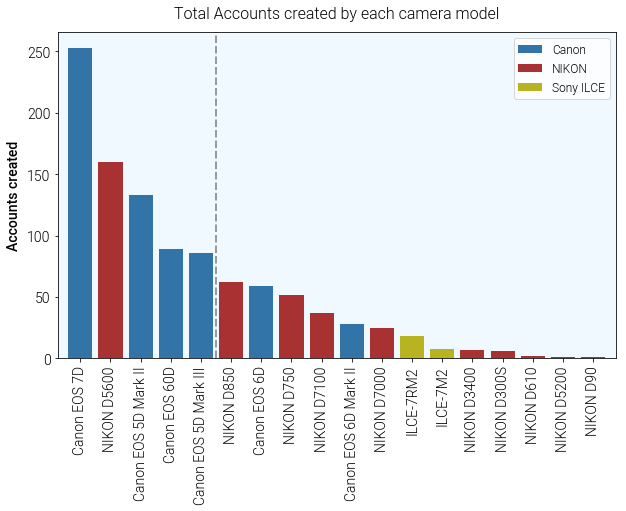

70% of Accounts were created using the top 5 camera models


In [39]:
x = range(len(df['model']))
y = df['counts']

plt.bar(x, y, color=[get_camera_color(c) for c in df['model']])
plt.axvline(x=4.5,color='black', alpha=0.5, dashes=(5,2))

plt.xticks(x, df['model'], rotation='vertical')
plt.ylabel('Accounts created')
plt.title('Total Accounts created by each camera model')
plt.xlim(-0.75, len(df['model'])-0.25)

cm = get_colormap('multi', 3)
legend_elements = [Patch(facecolor=cm(0), label='Canon'),
                   Patch(facecolor=cm(1), label='NIKON'),
                   Patch(facecolor=cm(2), label='Sony ILCE')]
plt.legend(handles=legend_elements)

plt.show()

top_models_percentile = int(sum(df['counts'][:5]) / sum(df['counts']) * 100)
print('{}% of Accounts were created using the top 5 camera models'.format(top_models_percentile))

There are certainly a good number of unique camera models used to photograph all the accounts.  (And Canon seems to be the favored brand).

However, we see a similar distribution here as with the "data_clientid" distribution.  I would guess that indeed there are only a few photographers responsible for most of the account creation.

## Conclusion

Overall, this is a small business.  It probably generates $30k - 40k in annual revenue.  However, fixed and variable costs are quite low.  This business is only for one small region of beach in South Carolina.  The same business could be duplicated to beaches all over the place.

While my sister has an excellent eye for photography, I do not, and so would not be too enthusiastic about starting such a business.  ***However***, if we were to get into the space, we would be armed with a solid operating strategy:

- Operate only during the summer months.  (Specifically, May 15 - September 15)
- Have a quick response time between taking the photos and making them available to the client.
- Keep the number of photos relatively low, no more than 100 per client.  (People don't like to trudge through mountains of so-so photos, plus it lowers operating costs)
- Keep our customer account information private.  (This should be a given, regardless!)
- Hire only a few contractors to take the photos.  (Or even do it ourselves; who doesn't like taking a trip to the beach?)

This business analysis is by no means complete, either.  We haven't explored the possibility of altering the business model (Hiring photographers directly vs. SaaS for freelancers), or of horizontally expanding the business to beachfronts all over the country.  There is also more in-depth analysis than could be accomplished from the cursory website scraping that this notebook is based on.  However, the analysis in this document provides a foundation from which to explore options.

More details: [Sven Zetterlund](https://www.svenzetterlund.com/hire-me)

In [40]:
print('Program took {} seconds to run on a Linode 2GB machine.'.format(int((datetime.now() - start_program).total_seconds())))

Program took 15 seconds to run on a Linode 2GB machine.
